In [32]:
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn import preprocessing
import numpy as np
from statsmodels.stats import inter_rater as irr
pd.options.display.max_colwidth = 240
from sklearn.preprocessing import OneHotEncoder
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
juanjo = pd.read_csv('../Data/Data_Annotated/latest_juanjo_annotations.csv', sep = '\t')
juanma = pd.read_csv('../Data/Data_Annotated/latest_juanma_annotations.csv', sep = '\t')
ger = pd.read_csv('../Data/Data_Annotated/latest_ger_annotations.csv', sep = '\t')
juanjo_final = pd.read_csv('../Data/Data_Annotated/final_juanjo_annotations.csv', sep = '\t')
juanma_final = pd.read_csv('../Data/Data_Annotated/final_juanma_annotations.csv', sep = '\t')
ger_final = pd.read_csv('../Data/Data_Annotated/final_ger_annotations.csv', sep = '\t')
juanjo = juanjo.append(juanjo_final)
juanma = juanma.append(juanma_final)
ger = ger.append(ger_final)

In [3]:
juanjo = juanjo.rename(columns = {'sentimento':'sentiment_juanjo', 'relevancia': 'relevancia_juanjo', 'emocion': 'emocion_juanjo', 'ironia': 'ironia_juanjo'})
juanma = juanma.rename(columns = {'sentimento':'sentiment_juanma', 'relevancia': 'relevancia_juanma', 'emocion': 'emocion_juanma', 'ironia': 'ironia_juanma'})
ger = ger.rename(columns = {'sentimento':'sentiment_ger', 'relevancia': 'relevancia_ger', 'emocion': 'emocion_ger', 'ironia': 'ironia_ger'})

In [4]:
merged_df = pd.merge(pd.merge(juanjo[['text', 'tweet_id', 'sentiment_juanjo']],
                     juanma[['tweet_id', 'sentiment_juanma']], on=['tweet_id']),
                    ger[['tweet_id', 'sentiment_ger']], on=['tweet_id'])

In [35]:
granular_emotions = ['Alegria', 'Agrado', 'Confianza', 'Admiración', 'Miedo', 'Incertidumbre',
                     'Sorpresa', 'Asombro', 'Tristeza', 'Decepción', 'Asco', 'Desagrado', 'Ira', 'Odio', 'Otra']

In [23]:
for i in granular_emotions: 
    merged_df[i + '_juanma'] = merged_df['sentiment_juanma'].str.contains(i)
    merged_df[i + '_juanjo'] = merged_df['sentiment_juanjo'].str.contains(i)
    merged_df[i + '_ger'] = merged_df['sentiment_ger'].str.contains(i)
merged_df = merged_df.fillna(False)

In [24]:
for emotion in granular_emotions: 
    merged_df[emotion] =  merged_df[[emotion + '_juanjo',  emotion + '_ger',  emotion + '_juanma']].sum(axis=1)
    merged_df[emotion] = np.where(merged_df[emotion]>= 1, True, False)

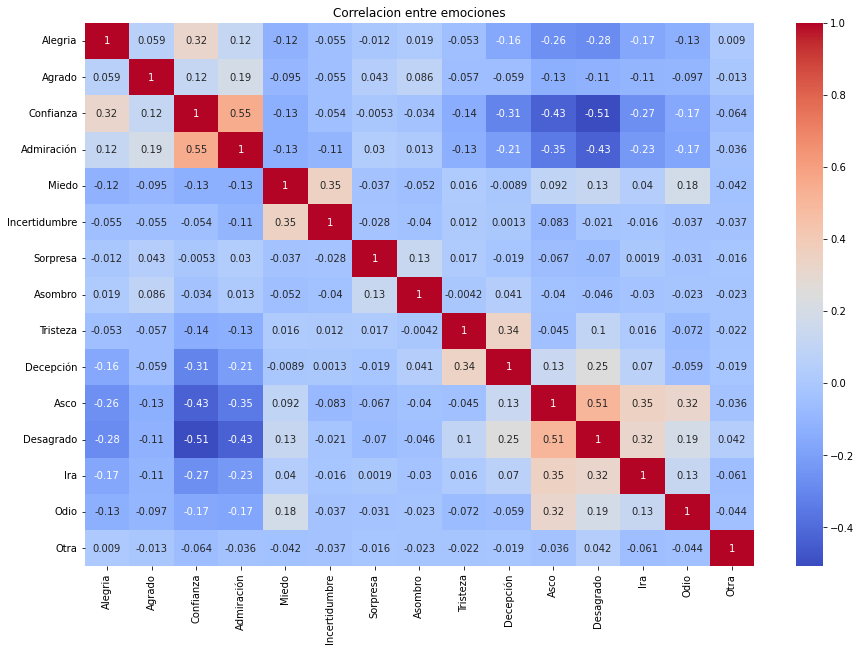

In [52]:
corr = merged_df[granular_emotions].corr()

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, cmap='coolwarm', ax=ax, annot=True, xticklabels=granular_emotions, yticklabels=granular_emotions)

plt.title('Correlacion entre emociones')
plt.savefig('../Images/EDA/emotions_correlations.png')
plt.show()

In [54]:
dict_emociones = {
    'alegria' : ['Alegria','Agrado','Confianza', 'Admiración'],
    'miedo' : ['Miedo', 'Incertidumbre'],
    'tristeza' : ['Tristeza' , 'Decepción'],
    'asco' : ['Asco', 'Desagrado','Ira', 'Odio' ] }
granular_emotions = [elem for lst in dict_emociones.values() for elem in lst]

In [55]:
for i  in dict_emociones.keys():
    merged_df[i + '_juanma'] = merged_df['sentiment_juanma'].str.contains('|'.join(dict_emociones[i]))
    merged_df[i + '_juanjo'] = merged_df['sentiment_juanjo'].str.contains('|'.join(dict_emociones[i]))
    merged_df[i + '_ger'] = merged_df['sentiment_ger'].str.contains('|'.join(dict_emociones[i]))

In [56]:
merged_df = merged_df.fillna(False)
merged_df['labels_author'] = merged_df.apply(lambda x: ', '.join(x.index[x == True]), axis=1)

In [59]:
for emotion in dict_emociones.keys():
    merged_df[emotion] =  merged_df[[emotion + '_juanjo',  emotion + '_ger',  emotion + '_juanma']].sum(axis=1)
    merged_df[emotion] = np.where(merged_df[emotion]>= 2, True, False)
merged_df['labels'] = merged_df[list(dict_emociones.keys())].apply(lambda x: ', '.join(x.index[x == True]), axis=1)
merged_df['labels_encoded'] = np.where(merged_df[list(dict_emociones.keys())] == 1, 1.0, 0.0).tolist()
labeled_df = merged_df[['text', 'tweet_id', 'labels', 'labels_encoded']]
labeled_df = labeled_df[labeled_df['labels'] != ''].reset_index(drop = True)
labeled_df.to_csv('../Data/Data_Annotated/reducted_test_labeled_dataset.csv', index = False)

In [60]:
emotions_count = {}
for i in dict_emociones.keys():
    emotions_count[i] =len(merged_df[merged_df[i] == True])
emotions_count

{'alegria': 464, 'miedo': 98, 'tristeza': 103, 'asco': 580}

In [61]:
agreements = {}
for i in dict_emociones.keys():
    arr = np.array(merged_df[[i + '_juanjo',i + '_juanma', i + '_ger' ]])
    agg = irr.aggregate_raters(arr)
    agreements[i] = irr.fleiss_kappa(agg[0], method='fleiss')
agreements

{'alegria': 0.6867465382749224,
 'miedo': 0.465564640154313,
 'tristeza': 0.39735183795949025,
 'asco': 0.6199361570009777}

In [62]:
labeled_df = pd.read_csv('../Data/Data_Annotated/reducted_test_labeled_dataset.csv')
labeled_df_hugging =  labeled_df[['text', 'labels_encoded']].rename(columns = {'labels_encoded' : 'labels'})
labeled_df_hugging.to_csv('../Data/Data_Annotated/reducted_labeled_dataset_hugging.csv', index = False)

In [22]:
labeled_df = pd.read_csv('../Data/Data_Annotated/test_labeled_dataset.csv')
labeled_df

,text,tweet_id,labels,labels_encoded
0,"#NosUnimosONosJodemos #NosUnimosONosJodemos Vamos juntos por el cambio, mire el miedo que le tienen. @petrogustavo Mi presidente",1528216296147533824,alegria,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,"@tobonsanin Otra vez este viejo estúpido politiquero, estamos es llevados cuando creemos viejo decrépito de estos va hacer la solución para Colombia, ayudando a escoger corruptos como #quintero en MEDELLIN #PetroElPatronDelMal #Federic...",1528425111078019072,"asco, ira","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]"
2,Sin importar encuestas como en el plebiscito juntos por Colombia el 29 nos vemos #FedericoImparable #NosUnimosONosJodemos #FedericoEsColombia,1528451337087762433,alegria,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,"Este es el Presidente que nos merecemos, recorrió el país entero, escuchó, expresó cariño y nos contagió la esperanza #FedericoEsColombia",1528336411451133955,alegria,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"Por mi familia, por la democracia y las libertades. #FedericoEsColombia",1528335860470620160,alegria,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...
415,"Gustavo Petro y Francia Márquez hoy es el día , #ElCambioEnPrimera está victoria no la Para nadie .#PetroPresidenteEnPrimera . #cambialahistoria .",1530864273974513666,alegria,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
416,"Ansioso por el cambio en primera es ahora! Por tus hijos, por los animales por el planeta y por vivir sabroso #PetroPresidenteEnPrimera",1530880576055562245,alegria,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
417,"@10jhonatan19 @EsConFajardo No luchan por ganar sino más bien para que no gané #PetroPresidenteEnPrimera .,... Pero no van a poder, los que queremos un cambio real somos más",1530895917607436288,"alegria, asco","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
418,"Vamos por el cambio en primera,votemos por un mejor pais #PetroPresidenteEnPrimera",1530895362671710209,alegria,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [32]:
literal_eval(labeled_df['labels_encoded'][0])

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [18]:
merged_df['labels_encoded'][0]

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [40]:
ironia_df = pd.merge(pd.merge(juanjo[[ 'tweet_id', 'ironia_juanjo']],
                     juanma[['tweet_id', 'ironia_juanma']], on=['tweet_id']),
                    ger[['tweet_id', 'ironia_ger']], on=['tweet_id'])
ironia_df = ironia_df.fillna('No')

In [44]:
ironia_df[ironia_df['ironia_ger'] == 'Si']

,tweet_id,ironia_juanjo,ironia_juanma,ironia_ger
44,1528756358622982144,No,No,Si
67,1528907950743597056,No,No,Si
79,1528918255418626052,Si,Si,Si
84,1528922981694676992,Si,Si,Si
85,1528923555882311685,No,No,Si
93,1528925095359655936,No,No,Si
126,1528946633701998593,No,No,Si
129,1528957102936432640,Si,No,Si
131,1529052116177801217,No,No,Si
163,1529403760224641026,No,No,Si
